In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import InputSpec, Dense, Wrapper, Input, concatenate
from tensorflow.keras.models import Model
import numpy as np


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=0, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()

        # initialise p
        self.p_logit = self.add_weight(name='p_logit',
                                       shape=(1,),
                                       initializer=tf.random_uniform_initializer(self.init_min, self.init_max),
                                       dtype=tf.dtypes.float32,
                                       trainable=True)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x, p):
        """
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        """
        eps = 1e-07
        temp = 0.1

        unif_noise = tf.random.uniform(shape=tf.shape(x))
        drop_prob = (
            tf.math.log(p + eps)
            - tf.math.log(1. - p + eps)
            + tf.math.log(unif_noise + eps)
            - tf.math.log(1. - unif_noise + eps)
        )
        drop_prob = tf.math.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        p = tf.math.sigmoid(self.p_logit)

        # initialise regulariser / prior KL term
        input_dim = inputs.shape[-1]  # last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * tf.reduce_sum(tf.square(weight)) / (1. - p)
        dropout_regularizer = p * tf.math.log(p) + (1. - p) * tf.math.log(1. - p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = tf.reduce_sum(kernel_regularizer + dropout_regularizer)
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs, p)), regularizer
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs, p)), regularizer

            return tf.keras.backend.in_train_phase(relaxed_dropped_inputs,
                                                   self.layer.call(inputs),
                                                   training=training), regularizer


def mse_loss(true, pred):
    n_outputs = pred.shape[1] // 2
    mean = pred[:, :n_outputs]
    return tf.reduce_mean((true - mean) ** 2, -1)


def heteroscedastic_loss(true, pred):
    n_outputs = pred.shape[1] // 2
    mean = pred[:, :n_outputs]
    log_var = pred[:, n_outputs:]
    precision = tf.math.exp(-log_var)
    return tf.reduce_sum(precision * (true - mean) ** 2. + log_var, -1)


def make_model(n_features, n_outputs, n_nodes=100, dropout_reg=1e-5, wd=0):
    losses = []
    inp = Input(shape=(n_features,))
    x = inp
    x, loss = ConcreteDropout(Dense(n_nodes, activation='relu'),
                              weight_regularizer=wd, dropout_regularizer=dropout_reg)(x)
    losses.append(loss)
    x, loss = ConcreteDropout(Dense(n_nodes, activation='relu'),
                              weight_regularizer=wd, dropout_regularizer=dropout_reg)(x)
    losses.append(loss)
    x, loss = ConcreteDropout(Dense(n_nodes, activation='relu'),
                              weight_regularizer=wd, dropout_regularizer=dropout_reg)(x)
    losses.append(loss)
    mean, loss = ConcreteDropout(Dense(n_outputs), weight_regularizer=wd, dropout_regularizer=dropout_reg)(x)
    losses.append(loss)
    log_var, loss = ConcreteDropout(Dense(n_outputs), weight_regularizer=wd, dropout_regularizer=dropout_reg)(x)
    losses.append(loss)
    out = concatenate([mean, log_var])
    model = Model(inp, out)
    for loss in losses:
        model.add_loss(loss)

    model.compile(optimizer=optimizers.Adam(), loss=heteroscedastic_loss, metrics=[mse_loss])
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 5, f'{len(model.losses)} is not 5'  # a loss for each Concrete Dropout layer

    return model


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import tensorshape_util

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

n_train = 90000


class MeanMetricWrapper(tfk.metrics.Mean):
    # code by @mcourteaux from https://github.com/tensorflow/probability/issues/742#issuecomment-580433644
    def __init__(self, fn, name=None, dtype=None, **kwargs):
        super(MeanMetricWrapper, self).__init__(name=name, dtype=dtype)
        self._fn = fn
        self._fn_kwargs = kwargs

    def update_state(self, y_true, y_pred, sample_weight=None):
        matches = self._fn(y_true, y_pred, **self._fn_kwargs)
        return super(MeanMetricWrapper, self).update_state(
            matches, sample_weight=sample_weight)

    def get_config(self):
        config = {}
        for k, v in self._fn_kwargs.items():
            config[k] = K.eval(v) if is_tensor_or_variable(v) else v
        base_config = super(MeanMetricWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def scaled_kl_fn(a, b, _):
    """
    idea from
    https://github.com/google-research/google-research/blob/9645220c865ab5603b377e6a98265631ece61d44/uq_benchmark_2019/uq_utils.py
    https://arxiv.org/pdf/1906.02530.pdf
    :param a: distribution
    :param b: distribution
    :return: scaled kl divergence
    """
    return tfd.kl_divergence(a, b) / n_train


def mmd_from_dists(a, b, _):
    p = a.distribution
    q = b.distribution

    num_reduce_dims = (tensorshape_util.rank(a.event_shape) -
                       tensorshape_util.rank(p.event_shape))
    gamma_sq = 0.5
    reduce_dims = [-i - 1 for i in range(0, num_reduce_dims)]
    for i in reduce_dims:
        gamma_sq *= a.event_shape[i]

    sigma_p = tf.convert_to_tensor(tf.square(p.scale))
    sigma_q = tf.convert_to_tensor(tf.square(q.scale))
    scale_pp = gamma_sq + 2 * sigma_p
    scale_qq = gamma_sq + 2 * sigma_q
    scale_cr = gamma_sq + sigma_p + sigma_q

    return tf.reduce_sum(
        tf.math.sqrt(gamma_sq / scale_pp) + tf.math.sqrt(gamma_sq / scale_qq)
        - 2 * tf.math.sqrt(gamma_sq / scale_cr) * tf.math.exp(
            -0.5 * tf.math.squared_difference(p.loc, q.loc) / scale_cr),
        axis=reduce_dims)


def negloglik(y_data, rv_y):
    return -rv_y.log_prob(y_data)


def negloglik_met(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(tf.cast(y_true, tf.float32)))


def mlp(hidden_dim=100, n_layers=3, n_inputs=13, dropout_rate=0, loss='mse'):
    input_data = tfkl.Input((n_inputs,))
    x = input_data
    for _ in range(n_layers):
        x = tfkl.Dense(hidden_dim, activation='relu')(x)
        if dropout_rate > 0:
            x = tfkl.Dropout(dropout_rate)(x)

    if loss == 'mse':
        x = tfkl.Dense(1)(x)
        model = tfk.Model(input_data, x)
        model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam())
    elif loss == 'nll':
        x = tfkl.Dense(2)(x)
        x = tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                         scale=1e-3 + tf.math.softplus(t[..., 1:])))(x)
        model = tfk.Model(input_data, x)
        model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik, metrics=['mse'])
    else:
        raise ValueError(f'Loss {loss} not implemented.')

    return model


def mlp_flipout(hidden_dim=100, n_layers=3, n_inputs=13, dropout_rate=0, kernel='kl'):
    input_img = tfkl.Input(n_inputs)
    x = input_img
    if kernel == 'kl':
        kernel_fn = scaled_kl_fn
    elif kernel == 'mmd':
        kernel_fn = mmd_from_dists
    else:
        raise ValueError(f'Kernel {kernel} not defined!')

    for _ in range(n_layers):
        x = tfpl.DenseFlipout(hidden_dim, activation='relu', kernel_divergence_fn=kernel_fn)(x)
        if dropout_rate > 0:
            x = tfkl.Dropout(dropout_rate)(x)
    x = tfpl.DenseFlipout(2, kernel_divergence_fn=kernel_fn)(x)
    x = tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                     scale=1e-3 + tf.math.softplus(t[..., 1:])))(x)
    model = tfk.Model(input_img, x)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss=negloglik,
                  metrics=['mse', MeanMetricWrapper(negloglik_met, name='nll')])

    return model


In [ ]:
import numpy as np
from scipy.special import gamma


def pendulum(n=10000, n_t=10, g_range=None, theta_range=None, ell_range=None, m_range=None, t_spread=None,
             ell_spread=None, seed=42):
    if g_range is None:
        g_range = [5, 15]
    if theta_range is None:
        theta_range = [5, 15]
    if ell_range is None:
        ell_range = [0.2, 0.8]
    if m_range is None:
        m_range = [0.02, 0.1]
    if t_spread is None:
        t_spread = [0.03, 0.03]
    if ell_spread is None:
        ell_spread = [0., 0.]

    np.random.seed(seed)

    g = (g_range[1] - g_range[0]) * np.random.rand(n) + g_range[0]
    theta = ((theta_range[1] - theta_range[0]) * np.random.rand(n) + theta_range[0]).reshape((n, 1))
    ell = ((ell_range[1] - ell_range[0]) * np.random.rand(n) + ell_range[0]).reshape((n, 1))
    m = ((m_range[1] - m_range[0]) * np.random.rand(n) + m_range[0]).reshape((n, 1))
    t = (2 * np.pi * np.sqrt(ell / g.reshape((n, 1))))

    t_scales = np.random.uniform(t_spread[0], t_spread[1], n)
    t_scales = np.repeat(t_scales, n_t).reshape((n, n_t))
    t_spreads = np.random.normal(scale=t_scales, size=(n, n_t))
    t_sigma = t_spreads * t
    t = t + t_sigma

    ell_scales = np.random.uniform(ell_spread[0], ell_spread[1], n).reshape((n, 1))
    ell_spreads = np.random.normal(scale=ell_scales, size=(n, 1))
    ell_sigma = ell_spreads * ell
    ell = ell + ell_sigma

    feat = np.concatenate([theta, ell, m, t], axis=1)
    y = g

    # statistical uncertainty
    delta_t = np.std(t_sigma, axis=1) / np.sqrt(2) * gamma((n_t-1)/2) / gamma(n_t/2)
    mean_t = np.mean(t, axis=1)
    ell = ell.reshape(n, )
    delta_ell = ell * ell_scales.reshape(n, )
    calc_y = 4 * np.pi ** 2 * ell / mean_t ** 2
    delta_y = 4 * np.pi ** 2 / mean_t ** 2 * np.sqrt((2 * ell * delta_t / mean_t) ** 2 + delta_ell ** 2)

    return feat, y, calc_y, delta_y


In [ ]:
from sklearn.preprocessing import MinMaxScaler


def scale(train_set, val_set, test_set=None, min_val=0, max_val=1, gap=0):
    scaler = MinMaxScaler((min_val+gap, max_val-gap))

    if train_set.ndim == 1:
        train_set = train_set.reshape(-1, 1)
        val_set = val_set.reshape(-1, 1)
        if test_set is not None:
            test_set = test_set.reshape(-1, 1)

    scaler.fit(train_set)
    train_set = scaler.transform(train_set)
    val_set = scaler.transform(val_set)
    if test_set is not None:
        test_set = scaler.transform(test_set)
        return scaler, train_set, val_set, test_set
    return scaler, train_set, val_set

In [ ]:
from sklearn.model_selection import train_test_split
import pickle
import argparse
import os
import numpy as np

val_proportion = 0.1
n_models = 10
n_neurons = 100


def main(model_type, t_spread_min, t_spread_max, ell_spread_min, ell_spread_max, n, n_test, n_epochs, data_dir):
    # Generate data
    feat, y, _, _ = pendulum(n=n, t_spread=[t_spread_min, t_spread_max], ell_spread=[ell_spread_min, ell_spread_max])

    # Set up data
    x_train, x_val, y_train, y_val = train_test_split(feat, y, test_size=val_proportion, random_state=42)
    x_scaler, x_train, x_val = scale(x_train, x_val)
    y_scaler, y_train, y_val = scale(y_train, y_val)

    t_range_str = f'trange{int(100*t_spread_min)}to{int(100*t_spread_max)}'
    model_name = f'{model_type}_{t_range_str}_{n_epochs}ep'

    os.makedirs(data_dir, exist_ok=True)

    if not os.path.isfile(f'{data_dir}x_scaler_{t_range_str}.pkl'):
        with open(f'{data_dir}x_scaler_{t_range_str}.pkl', 'wb') as file_pi:
            pickle.dump(x_scaler, file_pi)
        with open(f'{data_dir}y_scaler_{t_range_str}.pkl', 'wb') as file_pi:
            pickle.dump(y_scaler, file_pi)

    # train and save models
    model_number = 1
    while os.path.isfile(f'{data_dir}model_{model_name}_{str(model_number).zfill(3)}.h5'):
        model_number += 1

    if model_type == 'de':
        models = [mlp(loss='nll') for _ in range(n_models)]
    elif model_type == 'cd':
        n_features = x_train.shape[1]
        n_outputs = y_train.shape[1]
        dropout_reg = 2. / n
        models = [make_model(n_features, n_outputs, n_neurons, dropout_reg)]
    elif model_type == 'bnn':
        models = [mlp_flipout()]
    else:
        raise ValueError(f'Model type {model_type} not recognized!')

    for j, mod in enumerate(models):
        print(f'Model {j+1}')
        history = mod.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_val, y_val))
        mod.save_weights(f'{data_dir}model_{model_name}_{str(model_number+j).zfill(3)}.h5')
        with open(f'{data_dir}history_{model_name}_{str(model_number+j).zfill(3)}.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

    # Generate test set
    feat_test, _, _, _ = pendulum(n=n_test, t_spread=[t_spread_min, t_spread_max],
                                  ell_spread=[ell_spread_min, ell_spread_max], seed=666)
    feat_test = x_scaler.transform(feat_test)

    # make predictions
    if model_type == 'de':
        y_pred = []
        for model in models:
            y_pred.append(model(feat_test.astype('float32')))
    elif model_type == 'cd':
        y_pred = np.array([models[0].predict(feat_test) for _ in range(n_models)])
    elif model_type == 'bnn':
        y_pred = [models[0](feat_test.astype('float32')) for _ in range(n_models)]

    if model_type == 'de' or model_type == 'bnn':
        y_pred_val = [pred.loc.numpy() for pred in y_pred]
        y_pred_unc = [pred.scale.numpy() for pred in y_pred]
    elif model_type == 'cd':
        y_pred_val = y_pred[:, :, :1]
        y_pred_unc = np.sqrt(np.exp(y_pred[:, :, 1:]))

    y_pred_val_resc = [y_scaler.inverse_transform(y) for y in y_pred_val]
    y_pred_unc_resc = [y / y_scaler.scale_[0] for y in y_pred_unc]

    y_pred_val_resc = np.array(y_pred_val_resc).reshape((n_models, n_test))
    y_pred_unc_resc = np.array(y_pred_unc_resc).reshape((n_models, n_test))

    y_pred_mean = np.mean(y_pred_val_resc, axis=0)
    y_pred_ep_unc = np.std(y_pred_val_resc, axis=0)
    y_pred_al_unc = np.sqrt(np.mean(y_pred_unc_resc * y_pred_unc_resc, axis=0))
    y_pred_unc = np.sqrt(y_pred_al_unc ** 2 + y_pred_ep_unc ** 2)

    np.save(f'{data_dir}y_pred_test_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_mean)
    np.save(f'{data_dir}y_pred_test_alunc_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_al_unc)
    np.save(f'{data_dir}y_pred_test_epunc_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_ep_unc)
    np.save(f'{data_dir}y_pred_test_prunc_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_unc)


t_max = (0.05, 0.1, 0.2) # independent of model
t_spread_max = (0.1, 0.1, 0.1)

model_type = ('cd', 'bnn', 'de')
t_spread_min = (0.01, 0.01, 0.01)
t_spread_max = (0.1, 0.1, 0.1)
ell_spread_min = (0.02, 0.02, 0.02)
ell_spread_max = (0.02, 0.02, 0.02)
n = (90000, 90000, 90000)
n_test = (10000, 10000, 10000)
n_epochs = (100, 100, 20)
data_dir = ('data/', 'data/', 'data/')

for i in range(3):
  args = {'model_type': model_type[i],
          't_spread_min': t_spread_min[i],
          't_spread_max': t_spread_max[i],
          'ell_spread_min': ell_spread_min[i],
          'ell_spread_max': ell_spread_max[i],
          'n': n[i],
          'n_test': n_test[i],
          'n_epochs': n_epochs[i],
          'data_dir': data_dir[i]}
  main(**args)
%tb

Model 1
Epoch 1/100
2532/2532 [==============================] - 13s 4ms/step - loss: -3.4722 - mse_loss: 0.0197 - val_loss: -3.8845 - val_mse_loss: 0.0115
Epoch 2/100
2532/2532 [==============================] - 9s 4ms/step - loss: -4.3247 - mse_loss: 0.0082 - val_loss: -4.3967 - val_mse_loss: 0.0069
Epoch 3/100
2532/2532 [==============================] - 9s 4ms/step - loss: -4.5004 - mse_loss: 0.0069 - val_loss: -4.5932 - val_mse_loss: 0.0070
Epoch 4/100
2532/2532 [==============================] - 16s 6ms/step - loss: -4.6331 - mse_loss: 0.0057 - val_loss: -4.7284 - val_mse_loss: 0.0055
Epoch 5/100
2532/2532 [==============================] - 16s 6ms/step - loss: -4.7467 - mse_loss: 0.0050 - val_loss: -4.8264 - val_mse_loss: 0.0046
Epoch 6/100
2532/2532 [==============================] - 19s 8ms/step - loss: -4.7949 - mse_loss: 0.0048 - val_loss: -4.6111 - val_mse_loss: 0.0067
Epoch 7/100
2532/2532 [==============================] - 17s 7ms/step - loss: -4.8185 - mse_loss: 0.0046 -

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model 1
Epoch 1/100
2532/2532 [==============================] - 18s 6ms/step - loss: 0.2806 - mse: 0.0924 - nll: -0.3168 - val_loss: -0.0357 - val_mse: 0.0359 - val_nll: -0.6286
Epoch 2/100
2532/2532 [==============================] - 14s 6ms/step - loss: -0.1700 - mse: 0.0283 - nll: -0.7577 - val_loss: -0.2600 - val_mse: 0.0225 - val_nll: -0.8420
Epoch 3/100
2532/2532 [==============================] - 14s 6ms/step - loss: -0.3583 - mse: 0.0194 - nll: -0.9368 - val_loss: -0.4400 - val_mse: 0.0159 - val_nll: -1.0141
Epoch 4/100
2532/2532 [==============================] - 14s 5ms/step - loss: -0.4864 - mse: 0.0152 - nll: -1.0553 - val_loss: -0.5508 - val_mse: 0.0140 - val_nll: -1.1137
Epoch 5/100
2532/2532 [==============================] - 14s 6ms/step - loss: -0.5892 - mse: 0.0126 - nll: -1.1480 - val_loss: -0.6364 - val_mse: 0.0116 - val_nll: -1.1893
Epoch 6/100
2532/2532 [==============================] - 14s 5ms/step - loss: -0.6695 - mse: 0.0109 - nll: -1.2185 - val_loss: -0.704

No traceback available to show.


In [ ]:
import pickle
import argparse
import numpy as np

n_models = 10
n_neurons = 100

def main(model_type, model_number, t_spread_min, t_spread_max, ell_spread_min, ell_spread_max, ell_range_min,
         ell_range_max, g_range_min, g_range_max, n_test, n_epochs, data_dir):
    t_range_str = f'trange{int(100 * t_spread_min)}to{int(100 * t_spread_max)}'
    model_name = f'{model_type}_{t_range_str}_{n_epochs}ep'

    test_name = ''
    if ell_range_min != 2 or ell_range_max != 8:
        test_name += f'_ell{int(ell_range_min)}to{int(ell_range_max)}'
    if g_range_min != 5. or g_range_max != 15.:
        test_name += f'_g{int(g_range_min)}to{int(g_range_max)}'

    ell_range_min /= 10.
    ell_range_max /= 10.

    # Generate data
    feat_test, _, _, _ = pendulum(n=n_test, t_spread=[t_spread_min, t_spread_max],
                                  ell_range=[ell_range_min, ell_range_max], g_range=[g_range_min, g_range_max],
                                  ell_spread=[ell_spread_min, ell_spread_max], seed=666)

    with open(f'{data_dir}x_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        x_scaler = pickle.load(file_pi)
    with open(f'{data_dir}y_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        y_scaler = pickle.load(file_pi)

    feat_test = x_scaler.transform(feat_test)

    if model_type == 'de':
        models = [mlp(loss='nll') for _ in range(n_models)]
    elif model_type == 'cd':
        n_features = feat_test.shape[1]
        n_outputs = 1
        models = [make_model(n_features, n_outputs, n_neurons)]
    elif model_type == 'bnn':
        models = [mlp_flipout()]
    else:
        raise ValueError(f'Model type {model_type} not recognized!')

    for j, mod in enumerate(models):
        mod.load_weights(f'{data_dir}model_{model_name}_{str(model_number+j).zfill(3)}.h5')

    # make predictions
    if model_type == 'de':
        y_pred = []
        for model in models:
            y_pred.append(model(feat_test.astype('float32')))
    elif model_type == 'cd':
        y_pred = np.array([models[0].predict(feat_test) for _ in range(n_models)])
    elif model_type == 'bnn':
        y_pred = [models[0](feat_test.astype('float32')) for _ in range(n_models)]

    if model_type == 'de' or model_type == 'bnn':
        y_pred_val = [pred.loc.numpy() for pred in y_pred]
        y_pred_unc = [pred.scale.numpy() for pred in y_pred]
    elif model_type == 'cd':
        y_pred_val = y_pred[:, :, :1]
        y_pred_unc = np.sqrt(np.exp(y_pred[:, :, 1:]))

    y_pred_val_resc = [y_scaler.inverse_transform(y) for y in y_pred_val]
    y_pred_unc_resc = [y / y_scaler.scale_[0] for y in y_pred_unc]

    y_pred_val_resc = np.array(y_pred_val_resc).reshape((n_models, n_test))
    y_pred_unc_resc = np.array(y_pred_unc_resc).reshape((n_models, n_test))

    y_pred_mean = np.mean(y_pred_val_resc, axis=0)
    y_pred_ep_unc = np.std(y_pred_val_resc, axis=0)
    y_pred_al_unc = np.sqrt(np.mean(y_pred_unc_resc * y_pred_unc_resc, axis=0))
    y_pred_unc = np.sqrt(y_pred_al_unc ** 2 + y_pred_ep_unc ** 2)

    np.save(f'{data_dir}y_pred_test_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_mean)
    np.save(f'{data_dir}y_pred_test_alunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_al_unc)
    np.save(f'{data_dir}y_pred_test_epunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_ep_unc)
    np.save(f'{data_dir}y_pred_test_prunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_unc)

model_type = ('cd', 'bnn', 'de')
model_number = (1, 1, 1)
t_spread_min = (0.01, 0.01, 0.01)
t_spread_max = (0.1, 0.1, 0.1)
ell_spread_min = (0.02, 0.02, 0.02)
ell_spread_max = (0.02, 0.02, 0.02)
ell_range_min = (2, 2, 2)
ell_range_max = (8, 8, 8)
g_range_min = (5, 5, 5)
g_range_max = (15, 15, 15)
n_test = (10000, 10000, 10000)
n_epochs = (100, 100, 20)
data_dir = ('data/', 'data/', 'data/')

for i in range(3):
  args = {'model_type': model_type[i],
          'model_number': model_number[i],
          't_spread_min': t_spread_min[i],
          't_spread_max': t_spread_max[i],
          'ell_spread_min': ell_spread_min[i],
          'ell_spread_max': ell_spread_max[i],
          'ell_range_min' : ell_range_min[i],
          'ell_range_max' : ell_range_max[i],
          'g_range_min' : g_range_min[i],
          'g_range_max' : g_range_max[i],
          'n_test': n_test[i],
          'n_epochs': n_epochs[i],
          'data_dir': data_dir[i]}
  main(**args)

313/313 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
from sklearn.model_selection import train_test_split
import pickle
import argparse
import os
import numpy as np

val_proportion = 0.1
n_models = 10
n_neurons = 100


def main(model_type, t_spread_min, t_spread_max, ell_spread_min, ell_spread_max, n, n_test, n_epochs, data_dir):
    # Generate data
    feat, y, _, _ = pendulum(n=n, t_spread=[t_spread_min, t_spread_max], ell_spread=[ell_spread_min, ell_spread_max])

    # Set up data
    x_train, x_val, y_train, y_val = train_test_split(feat, y, test_size=val_proportion, random_state=42)
    x_scaler, x_train, x_val = scale(x_train, x_val)
    y_scaler, y_train, y_val = scale(y_train, y_val)

    t_range_str = f'trange{int(100*t_spread_min)}to{int(100*t_spread_max)}'
    model_name = f'{model_type}_{t_range_str}_{n_epochs}ep'

    os.makedirs(data_dir, exist_ok=True)

    if not os.path.isfile(f'{data_dir}x_scaler_{t_range_str}.pkl'):
        with open(f'{data_dir}x_scaler_{t_range_str}.pkl', 'wb') as file_pi:
            pickle.dump(x_scaler, file_pi)
        with open(f'{data_dir}y_scaler_{t_range_str}.pkl', 'wb') as file_pi:
            pickle.dump(y_scaler, file_pi)

    # train and save models
    model_number = 1
    while os.path.isfile(f'{data_dir}model_{model_name}_{str(model_number).zfill(3)}.h5'):
        model_number += 1

    if model_type == 'de':
        models = [mlp(loss='nll') for _ in range(n_models)]
    elif model_type == 'cd':
        n_features = x_train.shape[1]
        n_outputs = y_train.shape[1]
        dropout_reg = 2. / n
        models = [make_model(n_features, n_outputs, n_neurons, dropout_reg)]
    elif model_type == 'bnn':
        models = [mlp_flipout()]
    else:
        raise ValueError(f'Model type {model_type} not recognized!')

    for j, mod in enumerate(models):
        print(f'Model {j+1}')
        history = mod.fit(x_train, y_train, epochs=n_epochs, validation_data=(x_val, y_val))
        mod.save_weights(f'{data_dir}model_{model_name}_{str(model_number+j).zfill(3)}.h5')
        with open(f'{data_dir}history_{model_name}_{str(model_number+j).zfill(3)}.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

    # Generate test set
    feat_test, _, _, _ = pendulum(n=n_test, t_spread=[t_spread_min, t_spread_max],
                                  ell_spread=[ell_spread_min, ell_spread_max], seed=666)
    feat_test = x_scaler.transform(feat_test)

    # make predictions
    if model_type == 'de':
        y_pred = []
        for model in models:
            y_pred.append(model(feat_test.astype('float32')))
    elif model_type == 'cd':
        y_pred = np.array([models[0].predict(feat_test) for _ in range(n_models)])
    elif model_type == 'bnn':
        y_pred = [models[0](feat_test.astype('float32')) for _ in range(n_models)]

    if model_type == 'de' or model_type == 'bnn':
        y_pred_val = [pred.loc.numpy() for pred in y_pred]
        y_pred_unc = [pred.scale.numpy() for pred in y_pred]
    elif model_type == 'cd':
        y_pred_val = y_pred[:, :, :1]
        y_pred_unc = np.sqrt(np.exp(y_pred[:, :, 1:]))

    y_pred_val_resc = [y_scaler.inverse_transform(y) for y in y_pred_val]
    y_pred_unc_resc = [y / y_scaler.scale_[0] for y in y_pred_unc]

    y_pred_val_resc = np.array(y_pred_val_resc).reshape((n_models, n_test))
    y_pred_unc_resc = np.array(y_pred_unc_resc).reshape((n_models, n_test))

    y_pred_mean = np.mean(y_pred_val_resc, axis=0)
    y_pred_ep_unc = np.std(y_pred_val_resc, axis=0)
    y_pred_al_unc = np.sqrt(np.mean(y_pred_unc_resc * y_pred_unc_resc, axis=0))
    y_pred_unc = np.sqrt(y_pred_al_unc ** 2 + y_pred_ep_unc ** 2)

    np.save(f'{data_dir}y_pred_test_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_mean)
    np.save(f'{data_dir}y_pred_test_alunc_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_al_unc)
    np.save(f'{data_dir}y_pred_test_epunc_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_ep_unc)
    np.save(f'{data_dir}y_pred_test_prunc_{model_name}_{str(model_number).zfill(3)}.npy', y_pred_unc)


t_max = (0.05, 0.1, 0.2) # independent of model
t_spread_max = (0.1, 0.1, 0.1)

model_type = ('cd', 'bnn', 'de')
t_spread_min = (0.01, 0.01, 0.01)
t_spread_max = (0.2, 0.2, 0.2)
ell_spread_min = (0.02, 0.02, 0.02)
ell_spread_max = (0.02, 0.02, 0.02)
n = (90000, 90000, 90000)
n_test = (10000, 10000, 10000)
n_epochs = (100, 100, 20)
data_dir = ('data/', 'data/', 'data/')
for i in range(3):
  args = {'model_type': model_type[i],
          't_spread_min': t_spread_min[i],
          't_spread_max': t_spread_max[i],
          'ell_spread_min': ell_spread_min[i],
          'ell_spread_max': ell_spread_max[i],
          'n': n[i],
          'n_test': n_test[i],
          'n_epochs': n_epochs[i],
          'data_dir': data_dir[i]}
  main(**args)
%tb

Model 1
Epoch 1/100
2532/2532 [==============================] - 11s 3ms/step - loss: -3.0427 - mse_loss: 0.0240 - val_loss: -3.5429 - val_mse_loss: 0.0129
Epoch 2/100
2532/2532 [==============================] - 8s 3ms/step - loss: -3.7208 - mse_loss: 0.0112 - val_loss: -3.9202 - val_mse_loss: 0.0094
Epoch 3/100
2532/2532 [==============================] - 8s 3ms/step - loss: -3.8898 - mse_loss: 0.0095 - val_loss: -3.8500 - val_mse_loss: 0.0094
Epoch 4/100
2532/2532 [==============================] - 8s 3ms/step - loss: -4.0016 - mse_loss: 0.0086 - val_loss: -3.9226 - val_mse_loss: 0.0086
Epoch 5/100
2532/2532 [==============================] - 10s 4ms/step - loss: -4.0697 - mse_loss: 0.0080 - val_loss: -4.2552 - val_mse_loss: 0.0069
Epoch 6/100
2532/2532 [==============================] - 8s 3ms/step - loss: -4.1710 - mse_loss: 0.0074 - val_loss: -4.2511 - val_mse_loss: 0.0069
Epoch 7/100
2532/2532 [==============================] - 9s 3ms/step - loss: -4.2011 - mse_loss: 0.0071 - va

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model 1
Epoch 1/100
2532/2532 [==============================] - 17s 6ms/step - loss: 0.3873 - mse: 0.1120 - nll: -0.2092 - val_loss: 0.0913 - val_mse: 0.0468 - val_nll: -0.4990
Epoch 2/100
2532/2532 [==============================] - 14s 5ms/step - loss: -0.0307 - mse: 0.0369 - nll: -0.6161 - val_loss: -0.1255 - val_mse: 0.0300 - val_nll: -0.7065
Epoch 3/100
2532/2532 [==============================] - 14s 5ms/step - loss: -0.1792 - mse: 0.0279 - nll: -0.7546 - val_loss: -0.2322 - val_mse: 0.0253 - val_nll: -0.8036
Epoch 4/100
2532/2532 [==============================] - 13s 5ms/step - loss: -0.2730 - mse: 0.0234 - nll: -0.8379 - val_loss: -0.3014 - val_mse: 0.0234 - val_nll: -0.8595
Epoch 5/100
2532/2532 [==============================] - 13s 5ms/step - loss: -0.3436 - mse: 0.0211 - nll: -0.8975 - val_loss: -0.3571 - val_mse: 0.0200 - val_nll: -0.9054
Epoch 6/100
2532/2532 [==============================] - 13s 5ms/step - loss: -0.3960 - mse: 0.0191 - nll: -0.9385 - val_loss: -0.4190

No traceback available to show.


In [ ]:
import pickle
import argparse
import numpy as np

n_models = 10
n_neurons = 100

def main(model_type, model_number, t_spread_min, t_spread_max, ell_spread_min, ell_spread_max, ell_range_min,
         ell_range_max, g_range_min, g_range_max, n_test, n_epochs, data_dir):
    t_range_str = f'trange{int(100 * t_spread_min)}to{int(100 * t_spread_max)}'
    model_name = f'{model_type}_{t_range_str}_{n_epochs}ep'

    test_name = ''
    if ell_range_min != 2 or ell_range_max != 8:
        test_name += f'_ell{int(ell_range_min)}to{int(ell_range_max)}'
    if g_range_min != 5. or g_range_max != 15.:
        test_name += f'_g{int(g_range_min)}to{int(g_range_max)}'
    else:
    ell_range_min /= 10.
    ell_range_max /= 10.

    # Generate data
    feat_test, _, _, _ = pendulum(n=n_test, t_spread=[t_spread_min, t_spread_max],
                                  ell_range=[ell_range_min, ell_range_max], g_range=[g_range_min, g_range_max],
                                  ell_spread=[ell_spread_min, ell_spread_max], seed=666)

    with open(f'{data_dir}x_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        x_scaler = pickle.load(file_pi)
    with open(f'{data_dir}y_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        y_scaler = pickle.load(file_pi)

    feat_test = x_scaler.transform(feat_test)

    if model_type == 'de':
        models = [mlp(loss='nll') for _ in range(n_models)]
    elif model_type == 'cd':
        n_features = feat_test.shape[1]
        n_outputs = 1
        models = [make_model(n_features, n_outputs, n_neurons)]
    elif model_type == 'bnn':
        models = [mlp_flipout()]
    else:
        raise ValueError(f'Model type {model_type} not recognized!')

    for j, mod in enumerate(models):
        mod.load_weights(f'{data_dir}model_{model_name}_{str(model_number+j).zfill(3)}.h5')

    # make predictions
    if model_type == 'de':
        y_pred = []
        for model in models:
            y_pred.append(model(feat_test.astype('float32')))
    elif model_type == 'cd':
        y_pred = np.array([models[0].predict(feat_test) for _ in range(n_models)])
    elif model_type == 'bnn':
        y_pred = [models[0](feat_test.astype('float32')) for _ in range(n_models)]

    if model_type == 'de' or model_type == 'bnn':
        y_pred_val = [pred.loc.numpy() for pred in y_pred]
        y_pred_unc = [pred.scale.numpy() for pred in y_pred]
    elif model_type == 'cd':
        y_pred_val = y_pred[:, :, :1]
        y_pred_unc = np.sqrt(np.exp(y_pred[:, :, 1:]))

    y_pred_val_resc = [y_scaler.inverse_transform(y) for y in y_pred_val]
    y_pred_unc_resc = [y / y_scaler.scale_[0] for y in y_pred_unc]

    y_pred_val_resc = np.array(y_pred_val_resc).reshape((n_models, n_test))
    y_pred_unc_resc = np.array(y_pred_unc_resc).reshape((n_models, n_test))

    y_pred_mean = np.mean(y_pred_val_resc, axis=0)
    y_pred_ep_unc = np.std(y_pred_val_resc, axis=0)
    y_pred_al_unc = np.sqrt(np.mean(y_pred_unc_resc * y_pred_unc_resc, axis=0))
    y_pred_unc = np.sqrt(y_pred_al_unc ** 2 + y_pred_ep_unc ** 2)

    np.save(f'{data_dir}y_pred_test_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_mean)
    np.save(f'{data_dir}y_pred_test_alunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_al_unc)
    np.save(f'{data_dir}y_pred_test_epunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_ep_unc)
    np.save(f'{data_dir}y_pred_test_prunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_unc)

model_type = ('cd', 'bnn', 'de')
model_number = (1, 1, 1)
t_spread_min = (0.01, 0.01, 0.01)
t_spread_max = (0.2, 0.2, 0.2)
ell_spread_min = (0.02, 0.02, 0.02)
ell_spread_max = (0.02, 0.02, 0.02)
ell_range_min = (2, 2, 2)
ell_range_max = (8, 8, 8)
g_range_min = (5, 5, 5)
g_range_max = (15, 15, 15)
n_test = (10000, 10000, 10000)
n_epochs = (100, 100, 20)
data_dir = ('data/', 'data/', 'data/')

for i in range(3):
  args = {'model_type': model_type[i],
          'model_number': model_number[i],
          't_spread_min': t_spread_min[i],
          't_spread_max': t_spread_max[i],
          'ell_spread_min': ell_spread_min[i],
          'ell_spread_max': ell_spread_max[i],
          'ell_range_min' : ell_range_min[i],
          'ell_range_max' : ell_range_max[i],
          'g_range_min' : g_range_min[i],
          'g_range_max' : g_range_max[i],
          'n_test': n_test[i],
          'n_epochs': n_epochs[i],
          'data_dir': data_dir[i]}
  main(**args)

313/313 [==============================] - 3s 9ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.metrics import mean_squared_error


In [ ]:
from matplotlib import rcParams,rc
import matplotlib
rc('text', usetex=True)
rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

In [ ]:
def medians_from_scatter(x, y, n_bins=30, skip_end=5):
    left_lim = np.amin(x)
    right_lim = np.amax(x)
    right_lim += (right_lim - left_lim)/100000.
    bin_edges = np.linspace(left_lim, right_lim, n_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
    idxs = [np.logical_and(x >= bin_edges[i], x < bin_edges[i+1]) for i in np.arange(n_bins)]

    median = np.array([np.percentile(y[idx], 50) for idx in idxs[:-skip_end]])
    lower = np.array([np.percentile(y[idx], 16) for idx in idxs[:-skip_end]])
    upper = np.array([np.percentile(y[idx], 84) for idx in idxs[:-skip_end]])

    return bin_centers[:-skip_end], median, lower, upper

In [ ]:
def find_coverage(res, unc):
    sigma = np.abs(res/unc)
    cdf_sigma = 2*norm.cdf(sigma)-1
    x = np.linspace(0.01, 1, 100)
    coverage = [sum(cdf_sigma <= k)/nobject for k in x]
    return coverage

In [ ]:
# make a test set
nobject=10000

feat_test_t1to10, y_test_t1to10, calc_y_test_t1to10, delta_y_test_t1to10 = pendulum(n=nobject, t_spread=[0.01, 0.1],
                                                  ell_spread=[0.02, 0.02], seed=666)
feat_test_t1to20, y_test_t1to20, calc_y_test_t1to20, delta_y_test_t1to20 = pendulum(n=nobject, t_spread=[0.01, 0.2],
                                                  ell_spread=[0.02, 0.02], seed=666)

In [ ]:
y_pred_de_t1to10 = np.load('data/y_pred_test_de_trange1to10_20ep_001.npy')
y_pred_alunc_de_t1to10 = np.load('data/y_pred_test_alunc_de_trange1to10_20ep_001.npy')
y_pred_epunc_de_t1to10 = np.load('data/y_pred_test_epunc_de_trange1to10_20ep_001.npy')
y_pred_prunc_de_t1to10 = np.load('data/y_pred_test_prunc_de_trange1to10_20ep_001.npy')

In [ ]:
y_pred_de_t1to20 = np.load('data/y_pred_test_de_trange1to20_20ep_001.npy')
y_pred_alunc_de_t1to20 = np.load('data/y_pred_test_alunc_de_trange1to20_20ep_001.npy')
y_pred_epunc_de_t1to20 = np.load('data/y_pred_test_epunc_de_trange1to20_20ep_001.npy')
y_pred_prunc_de_t1to20 = np.load('data/y_pred_test_prunc_de_trange1to20_20ep_001.npy')

In [ ]:
y_pred_bnn_t1to10 = np.load('data/y_pred_test_bnn_trange1to10_100ep_001.npy')
y_pred_alunc_bnn_t1to10 = np.load('data/y_pred_test_alunc_bnn_trange1to10_100ep_001.npy')
y_pred_epunc_bnn_t1to10 = np.load('data/y_pred_test_epunc_bnn_trange1to10_100ep_001.npy')
y_pred_prunc_bnn_t1to10 = np.load('data/y_pred_test_prunc_bnn_trange1to10_100ep_001.npy')

In [ ]:
y_pred_bnn_t1to20 = np.load('data/y_pred_test_bnn_trange1to20_100ep_001.npy')
y_pred_alunc_bnn_t1to20 = np.load('data/y_pred_test_alunc_bnn_trange1to20_100ep_001.npy')
y_pred_epunc_bnn_t1to20 = np.load('data/y_pred_test_epunc_bnn_trange1to20_100ep_001.npy')
y_pred_prunc_bnn_t1to20 = np.load('data/y_pred_test_prunc_bnn_trange1to20_100ep_001.npy')

In [ ]:
y_pred_cd_t1to10 = np.load('data/y_pred_test_cd_trange1to10_100ep_001.npy')
y_pred_alunc_cd_t1to10 = np.load('data/y_pred_test_alunc_cd_trange1to10_100ep_001.npy')
y_pred_epunc_cd_t1to10 = np.load('data/y_pred_test_epunc_cd_trange1to10_100ep_001.npy')
y_pred_prunc_cd_t1to10 = np.load('data/y_pred_test_prunc_cd_trange1to10_100ep_001.npy')

In [ ]:
y_pred_cd_t1to20 = np.load('data/y_pred_test_cd_trange1to20_100ep_001.npy')
y_pred_alunc_cd_t1to20 = np.load('data/y_pred_test_alunc_cd_trange1to20_100ep_001.npy')
y_pred_epunc_cd_t1to20 = np.load('data/y_pred_test_epunc_cd_trange1to20_100ep_001.npy')
y_pred_prunc_cd_t1to20 = np.load('data/y_pred_test_prunc_cd_trange1to20_100ep_001.npy')

In [ ]:
analytic_t1to10, median_de_t1to10, low_de_t1to10, upp_de_t1to10 = medians_from_scatter(delta_y_test_t1to10/calc_y_test_t1to10,
                                                                                       y_pred_alunc_de_t1to10/y_pred_de_t1to10)
analytic_t1to20, median_de_t1to20, low_de_t1to20, upp_de_t1to20 = medians_from_scatter(delta_y_test_t1to20/calc_y_test_t1to20,
                                                                                       y_pred_alunc_de_t1to20/y_pred_de_t1to20)

In [ ]:
_, median_bnn_t1to10, low_bnn_t1to10, upp_bnn_t1to10 = medians_from_scatter(delta_y_test_t1to10/calc_y_test_t1to10,
                                                                            y_pred_alunc_bnn_t1to10/y_pred_bnn_t1to10)
_, median_bnn_t1to20, low_bnn_t1to20, upp_bnn_t1to20 = medians_from_scatter(delta_y_test_t1to20/calc_y_test_t1to20,
                                                                            y_pred_alunc_bnn_t1to20/y_pred_bnn_t1to20)

In [ ]:
_, median_cd_t1to10, low_cd_t1to10, upp_cd_t1to10 = medians_from_scatter(delta_y_test_t1to10/calc_y_test_t1to10,
                                                                         y_pred_alunc_cd_t1to10/y_pred_cd_t1to10)
_, median_cd_t1to20, low_cd_t1to20, upp_cd_t1to20 = medians_from_scatter(delta_y_test_t1to20/calc_y_test_t1to20,
                                                                         y_pred_alunc_cd_t1to20/y_pred_cd_t1to20)

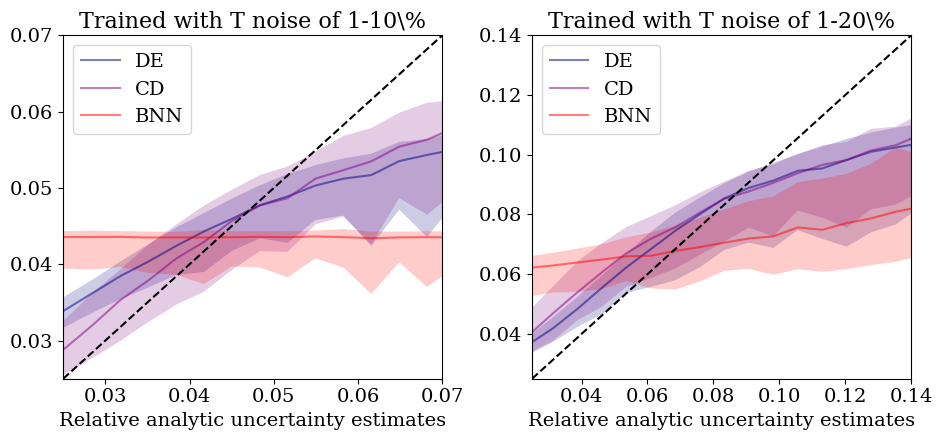

In [ ]:
fontsize=14
fontsize_title=16

plt.figure(figsize=(14,4.5))

ax0 = plt.subplot(131)
plt.plot(analytic_t1to10, median_de_t1to10, alpha=0.5, c='#000080', label='DE')
plt.fill_between(analytic_t1to10, low_de_t1to10, upp_de_t1to10,
                facecolor='#000080', alpha=0.2)
plt.plot(analytic_t1to10, median_cd_t1to10, alpha=0.5, c='#800080', label='CD')
plt.fill_between(analytic_t1to10, low_cd_t1to10, upp_cd_t1to10,
                facecolor='#800080', alpha=0.2)
plt.plot(analytic_t1to10, median_bnn_t1to10, alpha=0.5, c='#FF0000', label='BNN')
plt.fill_between(analytic_t1to10, low_bnn_t1to10, upp_bnn_t1to10,
                facecolor='#FF0000', alpha=0.2)
start_pt = 0.025
end_pt = 0.07
plt.plot([start_pt, end_pt], [start_pt, end_pt], '--', color=(0,0,0))
plt.xlim([start_pt, end_pt])
plt.ylim([start_pt, end_pt])
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Trained with T noise of 1-10\%', fontsize=fontsize_title)
plt.xlabel('Relative analytic uncertainty estimates', fontsize=fontsize)

ax0 = plt.subplot(132)
plt.plot(analytic_t1to20, median_de_t1to20, alpha=0.5, c='#000080', label='DE')
plt.fill_between(analytic_t1to20, low_de_t1to20, upp_de_t1to20,
                facecolor='#000080', alpha=0.2)
plt.plot(analytic_t1to20, median_cd_t1to20, alpha=0.5, c='#800080', label='CD')
plt.fill_between(analytic_t1to20, low_cd_t1to20, upp_cd_t1to20,
                facecolor='#800080', alpha=0.2)
plt.plot(analytic_t1to20, median_bnn_t1to20, alpha=0.5, c='#FF0000', label='BNN')
plt.fill_between(analytic_t1to20, low_bnn_t1to20, upp_bnn_t1to20,
                facecolor='#FF0000', alpha=0.2)
start_pt = 0.025
end_pt = 0.14
plt.plot([start_pt, end_pt], [start_pt, end_pt], '--', color=(0,0,0))
plt.xlim([start_pt, end_pt])
plt.ylim([start_pt, end_pt])
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Trained with T noise of 1-20\%', fontsize=fontsize_title)
plt.xlabel('Relative analytic uncertainty estimates', fontsize=fontsize)
plt.tight_layout()
plt.savefig('comparisons_diffnoise_perc.pdf', format='pdf', dpi=500)
plt.savefig('comparisons_diffnoise_perc.png', format='png', dpi=500)

In [ ]:
import pickle
import argparse
import numpy as np

n_models = 10
n_neurons = 100

def main(model_type, model_number, t_spread_min, t_spread_max, ell_spread_min, ell_spread_max, ell_range_min,
         ell_range_max, g_range_min, g_range_max, n_test, n_epochs, data_dir):
    t_range_str = f'trange{int(100 * t_spread_min)}to{int(100 * t_spread_max)}'
    model_name = f'{model_type}_{t_range_str}_{n_epochs}ep'

    test_name = ''
    test_name += f'_ell{int(ell_range_min)}to{int(ell_range_max)}'
    if g_range_min != 5. or g_range_max != 15.:
        test_name += f'_g{int(g_range_min)}to{int(g_range_max)}'

    ell_range_min /= 10.
    ell_range_max /= 10.

    # Generate data
    feat_test, _, _, _ = pendulum(n=n_test, t_spread=[t_spread_min, t_spread_max],
                                  ell_range=[ell_range_min, ell_range_max], g_range=[g_range_min, g_range_max],
                                  ell_spread=[ell_spread_min, ell_spread_max], seed=666)

    with open(f'{data_dir}x_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        x_scaler = pickle.load(file_pi)
    with open(f'{data_dir}y_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        y_scaler = pickle.load(file_pi)

    feat_test = x_scaler.transform(feat_test)

    if model_type == 'de':
        models = [mlp(loss='nll') for _ in range(n_models)]
    elif model_type == 'cd':
        n_features = feat_test.shape[1]
        n_outputs = 1
        models = [make_model(n_features, n_outputs, n_neurons)]
    elif model_type == 'bnn':
        models = [mlp_flipout()]
    else:
        raise ValueError(f'Model type {model_type} not recognized!')

    for j, mod in enumerate(models):
        mod.load_weights(f'{data_dir}model_{model_name}_{str(model_number+j).zfill(3)}.h5')

    # make predictions
    if model_type == 'de':
        y_pred = []
        for model in models:
            y_pred.append(model(feat_test.astype('float32')))
    elif model_type == 'cd':
        y_pred = np.array([models[0].predict(feat_test) for _ in range(n_models)])
    elif model_type == 'bnn':
        y_pred = [models[0](feat_test.astype('float32')) for _ in range(n_models)]

    if model_type == 'de' or model_type == 'bnn':
        y_pred_val = [pred.loc.numpy() for pred in y_pred]
        y_pred_unc = [pred.scale.numpy() for pred in y_pred]
    elif model_type == 'cd':
        y_pred_val = y_pred[:, :, :1]
        y_pred_unc = np.sqrt(np.exp(y_pred[:, :, 1:]))

    y_pred_val_resc = [y_scaler.inverse_transform(y) for y in y_pred_val]
    y_pred_unc_resc = [y / y_scaler.scale_[0] for y in y_pred_unc]

    y_pred_val_resc = np.array(y_pred_val_resc).reshape((n_models, n_test))
    y_pred_unc_resc = np.array(y_pred_unc_resc).reshape((n_models, n_test))

    y_pred_mean = np.mean(y_pred_val_resc, axis=0)
    y_pred_ep_unc = np.std(y_pred_val_resc, axis=0)
    y_pred_al_unc = np.sqrt(np.mean(y_pred_unc_resc * y_pred_unc_resc, axis=0))
    y_pred_unc = np.sqrt(y_pred_al_unc ** 2 + y_pred_ep_unc ** 2)

    np.save(f'{data_dir}y_pred_test_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_mean)
    np.save(f'{data_dir}y_pred_test_alunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_al_unc)
    np.save(f'{data_dir}y_pred_test_epunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_ep_unc)
    np.save(f'{data_dir}y_pred_test_prunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_unc)

model_type = ('cd', 'bnn', 'de')
model_number = (1, 1, 1)
t_spread_min = (0.01, 0.01, 0.01)
t_spread_max = (0.2, 0.2, 0.2)
ell_spread_min = (0.02, 0.02, 0.02)
ell_spread_max = (0.02, 0.02, 0.02)
ell_range_min = (2, 2, 2)
ell_range_max = (8, 8, 8)
g_range_min = (5, 5, 5)
g_range_max = (15, 15, 15)
n_test = (10000, 10000, 10000)
n_epochs = (100, 100, 20)
data_dir = ('data/', 'data/', 'data/')
for i in range(3):
    for j in range(2, 17):
      for k in range(j + 1, 17):
        ell_range_min = (j, j, j)
        ell_range_max = (k, k, k)
        args = {'model_type': model_type[i],
              'model_number': model_number[i],
              't_spread_min': t_spread_min[i],
              't_spread_max': t_spread_max[i],
              'ell_spread_min': ell_spread_min[i],
              'ell_spread_max': ell_spread_max[i],
              'ell_range_min' : ell_range_min[i],
              'ell_range_max' : ell_range_max[i],
              'g_range_min' : g_range_min[i],
              'g_range_max' : g_range_max[i],
              'n_test': n_test[i],
              'n_epochs': n_epochs[i],
              'data_dir': data_dir[i]}
        main(**args)

313/313 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` met

In [ ]:
y_pred_bnn_oodl = []
y_pred_alunc_bnn_oodl = []
y_pred_epunc_bnn_oodl = []
y_pred_prunc_bnn_oodl = []
for i in range(2, 16):
    y_pred_bnn_oodl.append(np.load(f'data/y_pred_test_bnn_trange1to20_100ep_001_ell{i}to{i+1}.npy'))
    y_pred_alunc_bnn_oodl.append(np.load(f'data/y_pred_test_alunc_bnn_trange1to20_100ep_001_ell{i}to{i+1}.npy'))
    y_pred_epunc_bnn_oodl.append(np.load(f'data/y_pred_test_epunc_bnn_trange1to20_100ep_001_ell{i}to{i+1}.npy'))
    y_pred_prunc_bnn_oodl.append(np.load(f'data/y_pred_test_prunc_bnn_trange1to20_100ep_001_ell{i}to{i+1}.npy'))

y_pred_de_oodl = []
y_pred_alunc_de_oodl = []
y_pred_epunc_de_oodl = []
y_pred_prunc_de_oodl = []
for i in range(2, 16):
    y_pred_de_oodl.append(np.load(f'data/y_pred_test_de_trange1to20_20ep_001_ell{i}to{i+1}.npy'))
    y_pred_alunc_de_oodl.append(np.load(f'data/y_pred_test_alunc_de_trange1to20_20ep_001_ell{i}to{i+1}.npy'))
    y_pred_epunc_de_oodl.append(np.load(f'data/y_pred_test_epunc_de_trange1to20_20ep_001_ell{i}to{i+1}.npy'))
    y_pred_prunc_de_oodl.append(np.load(f'data/y_pred_test_prunc_de_trange1to20_20ep_001_ell{i}to{i+1}.npy'))

y_pred_cd_oodl = []
y_pred_alunc_cd_oodl = []
y_pred_epunc_cd_oodl = []
y_pred_prunc_cd_oodl = []
for i in range(2, 16):
    y_pred_cd_oodl.append(np.load(f'data/y_pred_test_cd_trange1to20_100ep_001_ell{i}to{i+1}.npy'))
    y_pred_alunc_cd_oodl.append(np.load(f'data/y_pred_test_alunc_cd_trange1to20_100ep_001_ell{i}to{i+1}.npy'))
    y_pred_epunc_cd_oodl.append(np.load(f'data/y_pred_test_epunc_cd_trange1to20_100ep_001_ell{i}to{i+1}.npy'))
    y_pred_prunc_cd_oodl.append(np.load(f'data/y_pred_test_prunc_cd_trange1to20_100ep_001_ell{i}to{i+1}.npy'))

In [ ]:
y_pred_epunc_bnn_oodl_50 = np.percentile(y_pred_epunc_bnn_oodl, 50, axis=1)
y_pred_epunc_cd_oodl_50 = np.percentile(y_pred_epunc_cd_oodl, 50, axis=1)
y_pred_epunc_de_oodl_50 = np.percentile(y_pred_epunc_de_oodl, 50, axis=1)
y_pred_epunc_bnn_oodl_16 = np.percentile(y_pred_epunc_bnn_oodl, 16, axis=1)
y_pred_epunc_cd_oodl_16 = np.percentile(y_pred_epunc_cd_oodl, 16, axis=1)
y_pred_epunc_de_oodl_16 = np.percentile(y_pred_epunc_de_oodl, 16, axis=1)
y_pred_epunc_bnn_oodl_84 = np.percentile(y_pred_epunc_bnn_oodl, 84, axis=1)
y_pred_epunc_cd_oodl_84 = np.percentile(y_pred_epunc_cd_oodl, 84, axis=1)
y_pred_epunc_de_oodl_84 = np.percentile(y_pred_epunc_de_oodl, 84, axis=1)

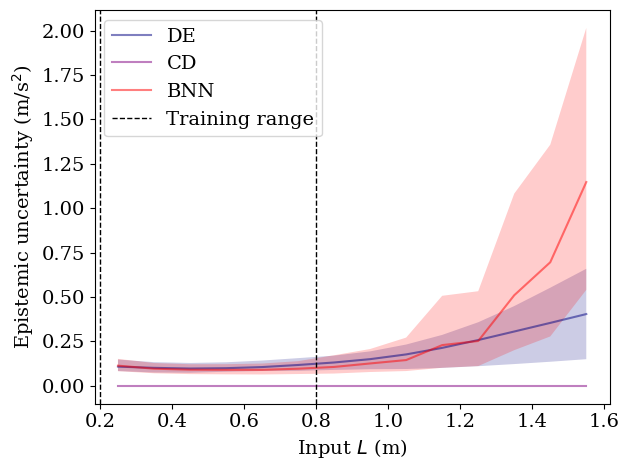

In [ ]:
fontsize=14
fontsize_title=16

x = np.arange(0.25, 1.6, 0.1)
plt.plot(x, y_pred_epunc_de_oodl_50, alpha=0.5, c='#000080', label='DE')
plt.fill_between(x, y_pred_epunc_de_oodl_16, y_pred_epunc_de_oodl_84,
                facecolor='#000080', alpha=0.2)
plt.plot(x, y_pred_epunc_cd_oodl_50, alpha=0.5, c='#800080', label='CD')
plt.fill_between(x, y_pred_epunc_cd_oodl_16, y_pred_epunc_cd_oodl_84,
                facecolor='#800080', alpha=0.2)
plt.plot(x, y_pred_epunc_bnn_oodl_50, alpha=0.5, c='#FF0000', label='BNN')
plt.fill_between(x, y_pred_epunc_bnn_oodl_16, y_pred_epunc_bnn_oodl_84,
                facecolor='#FF0000', alpha=0.2)
plt.axvline(0.2, ls='--', c='black', linewidth=1)
plt.axvline(0.8, ls='--', c='black', linewidth=1, label='Training range')

plt.legend(fontsize=fontsize, loc=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Input $L$ (m)', fontsize=fontsize)
plt.ylabel('Epistemic uncertainty (m/s$^2$)', fontsize=fontsize)
plt.tight_layout()
plt.savefig('oodl.pdf', format='pdf', dpi=500)
plt.savefig('oodl.png', format='png', dpi=500)

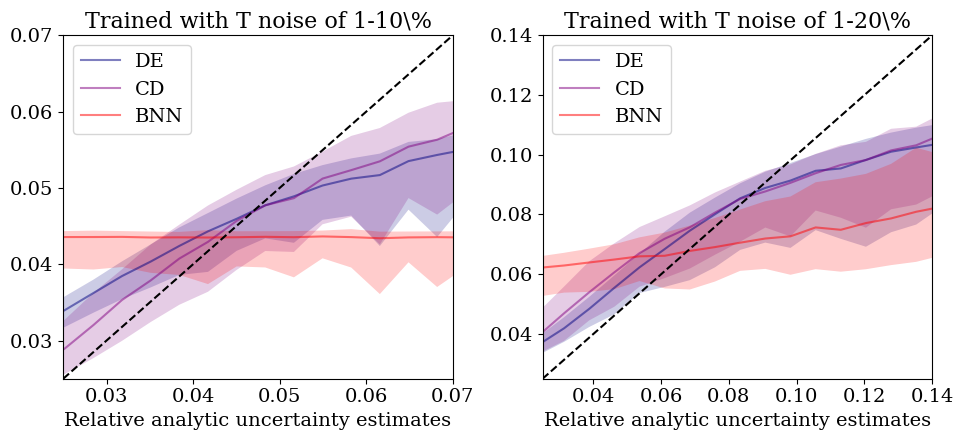

In [ ]:
fontsize=14
fontsize_title=16

plt.figure(figsize=(14,4.5))

ax0 = plt.subplot(132)
plt.plot(analytic_t1to10, median_de_t1to10, alpha=0.5, c='#000080', label='DE')
plt.fill_between(analytic_t1to10, low_de_t1to10, upp_de_t1to10,
                facecolor='#000080', alpha=0.2)
plt.plot(analytic_t1to10, median_cd_t1to10, alpha=0.5, c='#800080', label='CD')
plt.fill_between(analytic_t1to10, low_cd_t1to10, upp_cd_t1to10,
                facecolor='#800080', alpha=0.2)
plt.plot(analytic_t1to10, median_bnn_t1to10, alpha=0.5, c='#FF0000', label='BNN')
plt.fill_between(analytic_t1to10, low_bnn_t1to10, upp_bnn_t1to10,
                facecolor='#FF0000', alpha=0.2)
start_pt = 0.025
end_pt = 0.07
plt.plot([start_pt, end_pt], [start_pt, end_pt], '--', color=(0,0,0))
plt.xlim([start_pt, end_pt])
plt.ylim([start_pt, end_pt])
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Trained with T noise of 1-10\%', fontsize=fontsize_title)
plt.xlabel('Relative analytic uncertainty estimates', fontsize=fontsize)

ax0 = plt.subplot(133)
plt.plot(analytic_t1to20, median_de_t1to20, alpha=0.5, c='#000080', label='DE')
plt.fill_between(analytic_t1to20, low_de_t1to20, upp_de_t1to20,
                facecolor='#000080', alpha=0.2)
plt.plot(analytic_t1to20, median_cd_t1to20, alpha=0.5, c='#800080', label='CD')
plt.fill_between(analytic_t1to20, low_cd_t1to20, upp_cd_t1to20,
                facecolor='#800080', alpha=0.2)
plt.plot(analytic_t1to20, median_bnn_t1to20, alpha=0.5, c='#FF0000', label='BNN')
plt.fill_between(analytic_t1to20, low_bnn_t1to20, upp_bnn_t1to20,
                facecolor='#FF0000', alpha=0.2)
start_pt = 0.025
end_pt = 0.14
plt.plot([start_pt, end_pt], [start_pt, end_pt], '--', color=(0,0,0))
plt.xlim([start_pt, end_pt])
plt.ylim([start_pt, end_pt])
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Trained with T noise of 1-20\%', fontsize=fontsize_title)
plt.xlabel('Relative analytic uncertainty estimates', fontsize=fontsize)
plt.tight_layout()
plt.savefig('comparisons_diffnoise_perc.pdf', format='pdf', dpi=500)
plt.savefig('comparisons_diffnoise_perc.png', format='png', dpi=500)

In [ ]:
residuals_de = y_pred_de_t1to20 - y_test_t1to20
residuals_cd = y_pred_cd_t1to20 - y_test_t1to20
residuals_bnn = y_pred_bnn_t1to20 - y_test_t1to20

In [ ]:
coverage_de = find_coverage(residuals_de, y_pred_prunc_de_t1to20)
coverage_cd = find_coverage(residuals_cd, y_pred_prunc_cd_t1to20)
coverage_bnn = find_coverage(residuals_bnn, y_pred_prunc_bnn_t1to20)

In [ ]:
y_pred_de_t1to20_8to12 = np.load('data/y_pred_test_de_trange1to20_20ep_001_ell8to12.npy')
y_pred_prunc_de_t1to20_8to12 = np.load('data/y_pred_test_prunc_de_trange1to20_20ep_001_ell8to12.npy')

y_pred_cd_t1to20_8to12 = np.load('data/y_pred_test_cd_trange1to20_100ep_001_ell8to12.npy')
y_pred_prunc_cd_t1to20_8to12 = np.load('data/y_pred_test_prunc_cd_trange1to20_100ep_001_ell8to12.npy')

y_pred_bnn_t1to20_8to12 = np.load('data/y_pred_test_bnn_trange1to20_100ep_001_ell8to12.npy')
y_pred_prunc_bnn_t1to20_8to12 = np.load('data//y_pred_test_prunc_bnn_trange1to20_100ep_001_ell8to12.npy')

In [ ]:
y_pred_de_t1to20_12to16 = np.load('data/y_pred_test_de_trange1to20_20ep_001_ell12to16.npy')
y_pred_prunc_de_t1to20_12to16 = np.load('data/y_pred_test_prunc_de_trange1to20_20ep_001_ell12to16.npy')

y_pred_cd_t1to20_12to16 = np.load('data/y_pred_test_cd_trange1to20_100ep_001_ell12to16.npy')
y_pred_prunc_cd_t1to20_12to16 = np.load('data/y_pred_test_prunc_cd_trange1to20_100ep_001_ell12to16.npy')

y_pred_bnn_t1to20_12to16 = np.load('data/y_pred_test_bnn_trange1to20_100ep_001_ell12to16.npy')
y_pred_prunc_bnn_t1to20_12to16 = np.load('data//y_pred_test_prunc_bnn_trange1to20_100ep_001_ell12to16.npy')

In [ ]:
feat_test_t1to20_8to12, y_test_t1to20_8to12, calc_y_test_t1to20_8to12, delta_y_test_t1to20_8to12 = pendulum(n=nobject, t_spread=[0.01, 0.2],
                                                  ell_spread=[0.02, 0.02], seed=666, ell_range=[0.8, 1.2])

In [ ]:
feat_test_t1to20_12to16, y_test_t1to20_12to16, calc_y_test_t1to20_12to16, delta_y_test_t1to20_12to16 = pendulum(n=nobject, t_spread=[0.01, 0.2],
                                                  ell_spread=[0.02, 0.02], seed=666, ell_range=[1.2, 1.6])

In [ ]:
residuals_de_8to12 = y_pred_de_t1to20_8to12 - y_test_t1to20_8to12
residuals_cd_8to12 = y_pred_cd_t1to20_8to12 - y_test_t1to20_8to12
residuals_bnn_8to12 = y_pred_bnn_t1to20_8to12 - y_test_t1to20_8to12

residuals_de_12to16 = y_pred_de_t1to20_12to16 - y_test_t1to20_12to16
residuals_cd_12to16 = y_pred_cd_t1to20_12to16 - y_test_t1to20_12to16
residuals_bnn_12to16 = y_pred_bnn_t1to20_12to16 - y_test_t1to20_12to16

In [ ]:
coverage_de_8to12 = find_coverage(residuals_de_8to12, y_pred_prunc_de_t1to20_8to12)
coverage_cd_8to12 = find_coverage(residuals_cd_8to12, y_pred_prunc_cd_t1to20_8to12)
coverage_bnn_8to12 = find_coverage(residuals_bnn_8to12, y_pred_prunc_bnn_t1to20_8to12)

coverage_de_12to16 = find_coverage(residuals_de_12to16, y_pred_prunc_de_t1to20_12to16)
coverage_cd_12to16 = find_coverage(residuals_cd_12to16, y_pred_prunc_cd_t1to20_12to16)
coverage_bnn_12to16 = find_coverage(residuals_bnn_12to16, y_pred_prunc_bnn_t1to20_12to16)

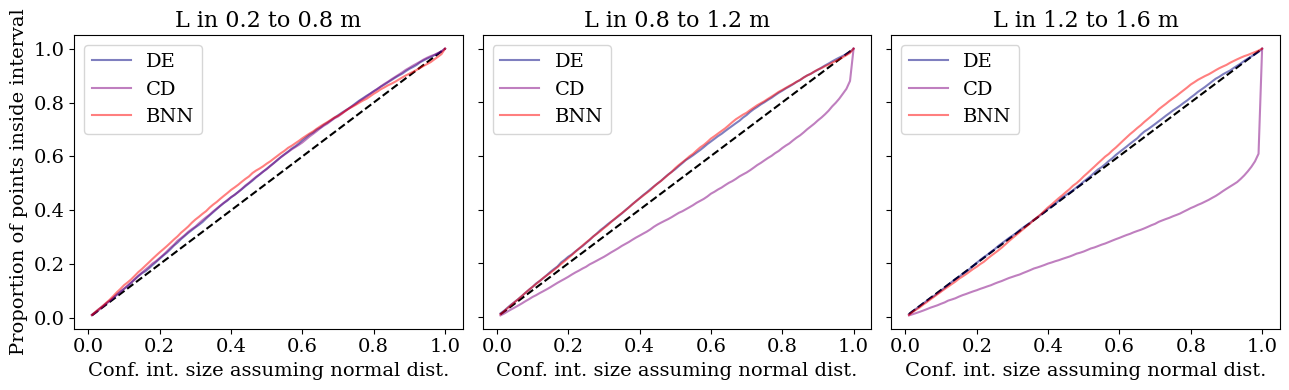

In [ ]:
x = np.linspace(0.01, 1, 100)

fontsize=14
fontsize_title=16

plt.figure(figsize=(13,4))

ax0 = plt.subplot(131)
plt.plot(x, x, ls='--', c=(0,0,0))
plt.plot(x, coverage_de, label='DE', c='#000080', alpha=0.5)
plt.plot(x, coverage_cd, label='CD', c='#800080', alpha=0.5)
plt.plot(x, coverage_bnn, label='BNN', c='#FF0000', alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Conf. int. size assuming normal dist.', fontsize=fontsize)
plt.ylabel('Proportion of points inside interval', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('L in 0.2 to 0.8 m', fontsize=fontsize_title)

ax0 = plt.subplot(132)
plt.plot(x, x, ls='--', c=(0,0,0))
plt.plot(x, coverage_de_8to12, label='DE', c='#000080', alpha=0.5)
plt.plot(x, coverage_cd_8to12, label='CD', c='#800080', alpha=0.5)
plt.plot(x, coverage_bnn_8to12, label='BNN', c='#FF0000', alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Conf. int. size assuming normal dist.', fontsize=fontsize)
plt.setp(ax0.get_yticklabels(), visible=False)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('L in 0.8 to 1.2 m', fontsize=fontsize_title)
plt.subplots_adjust(wspace=0., hspace=0.)

ax0 = plt.subplot(133)
plt.plot(x, x, ls='--', c=(0,0,0))
plt.plot(x, coverage_de_12to16, label='DE', c='#000080', alpha=0.5)
plt.plot(x, coverage_cd_12to16, label='CD', c='#800080', alpha=0.5)
plt.plot(x, coverage_bnn_12to16, label='BNN', c='#FF0000', alpha=0.5)
plt.legend(fontsize=fontsize)
plt.xlabel('Conf. int. size assuming normal dist.', fontsize=fontsize)
plt.setp(ax0.get_yticklabels(), visible=False)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('L in 1.2 to 1.6 m', fontsize=fontsize_title)
plt.tight_layout()
plt.savefig('calibration_changingell.pdf', format='pdf', dpi=500)
plt.savefig('calibration_changingell.png', format='png', dpi=500)

In [ ]:
import pickle
import argparse
import numpy as np

n_models = 10
n_neurons = 100

def main(model_type, model_number, t_spread_min, t_spread_max, ell_spread_min, ell_spread_max, ell_range_min,
         ell_range_max, g_range_min, g_range_max, n_test, n_epochs, data_dir):
    t_range_str = f'trange{int(100 * t_spread_min)}to{int(100 * t_spread_max)}'
    model_name = f'{model_type}_{t_range_str}_{n_epochs}ep'

    test_name = ''
    test_name += f'_g{int(g_range_min)}to{int(g_range_max)}'

    ell_range_min /= 10.
    ell_range_max /= 10.

    # Generate data
    feat_test, _, _, _ = pendulum(n=n_test, t_spread=[t_spread_min, t_spread_max],
                                  ell_range=[ell_range_min, ell_range_max], g_range=[g_range_min, g_range_max],
                                  ell_spread=[ell_spread_min, ell_spread_max], seed=666)

    with open(f'{data_dir}x_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        x_scaler = pickle.load(file_pi)
    with open(f'{data_dir}y_scaler_{t_range_str}.pkl', 'rb') as file_pi:
        y_scaler = pickle.load(file_pi)

    feat_test = x_scaler.transform(feat_test)

    if model_type == 'de':
        models = [mlp(loss='nll') for _ in range(n_models)]
    elif model_type == 'cd':
        n_features = feat_test.shape[1]
        n_outputs = 1
        models = [make_model(n_features, n_outputs, n_neurons)]
    elif model_type == 'bnn':
        models = [mlp_flipout()]
    else:
        raise ValueError(f'Model type {model_type} not recognized!')

    for j, mod in enumerate(models):
        mod.load_weights(f'{data_dir}model_{model_name}_{str(model_number+j).zfill(3)}.h5')

    # make predictions
    if model_type == 'de':
        y_pred = []
        for model in models:
            y_pred.append(model(feat_test.astype('float32')))
    elif model_type == 'cd':
        y_pred = np.array([models[0].predict(feat_test) for _ in range(n_models)])
    elif model_type == 'bnn':
        y_pred = [models[0](feat_test.astype('float32')) for _ in range(n_models)]

    if model_type == 'de' or model_type == 'bnn':
        y_pred_val = [pred.loc.numpy() for pred in y_pred]
        y_pred_unc = [pred.scale.numpy() for pred in y_pred]
    elif model_type == 'cd':
        y_pred_val = y_pred[:, :, :1]
        y_pred_unc = np.sqrt(np.exp(y_pred[:, :, 1:]))

    y_pred_val_resc = [y_scaler.inverse_transform(y) for y in y_pred_val]
    y_pred_unc_resc = [y / y_scaler.scale_[0] for y in y_pred_unc]

    y_pred_val_resc = np.array(y_pred_val_resc).reshape((n_models, n_test))
    y_pred_unc_resc = np.array(y_pred_unc_resc).reshape((n_models, n_test))

    y_pred_mean = np.mean(y_pred_val_resc, axis=0)
    y_pred_ep_unc = np.std(y_pred_val_resc, axis=0)
    y_pred_al_unc = np.sqrt(np.mean(y_pred_unc_resc * y_pred_unc_resc, axis=0))
    y_pred_unc = np.sqrt(y_pred_al_unc ** 2 + y_pred_ep_unc ** 2)

    np.save(f'{data_dir}y_pred_test_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_mean)
    np.save(f'{data_dir}y_pred_test_alunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_al_unc)
    np.save(f'{data_dir}y_pred_test_epunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_ep_unc)
    np.save(f'{data_dir}y_pred_test_prunc_{model_name}_{str(model_number).zfill(3)}{test_name}.npy', y_pred_unc)

model_type = ('cd', 'bnn', 'de')
model_number = (1, 1, 1)
t_spread_min = (0.01, 0.01, 0.01)
t_spread_max = (0.2, 0.2, 0.2)
ell_spread_min = (0.02, 0.02, 0.02)
ell_spread_max = (0.02, 0.02, 0.02)
ell_range_min = (2, 2, 2)
ell_range_max = (8, 8, 8)
g_range_min = (5, 5, 5)
g_range_max = (15, 15, 15)
n_test = (10000, 10000, 10000)
n_epochs = (100, 100, 20)
data_dir = ('data/', 'data/', 'data/')
for i in range(3):
    for j in range(10, 25):
      for k in range(j + 1 , 26):
        g_range_min = (j, j, j)
        g_range_max = (k, k, k)
        args = {'model_type': model_type[i],
              'model_number': model_number[i],
              't_spread_min': t_spread_min[i],
              't_spread_max': t_spread_max[i],
              'ell_spread_min': ell_spread_min[i],
              'ell_spread_max': ell_spread_max[i],
              'ell_range_min' : ell_range_min[i],
              'ell_range_max' : ell_range_max[i],
              'g_range_min' : g_range_min[i],
              'g_range_max' : g_range_max[i],
              'n_test': n_test[i],
              'n_epochs': n_epochs[i],
              'data_dir': data_dir[i]}
        main(**args)

In [ ]:
y_pred_bnn_oodg = []
y_pred_alunc_bnn_oodg = []
y_pred_epunc_bnn_oodg = []
y_pred_prunc_bnn_oodg = []
for i in range(10, 25):
    y_pred_bnn_oodg.append(np.load(f'data/y_pred_test_bnn_trange1to20_100ep_001_g{i}to{i+1}.npy'))
    y_pred_alunc_bnn_oodg.append(np.load(f'data/y_pred_test_alunc_bnn_trange1to20_100ep_001_g{i}to{i+1}.npy'))
    y_pred_epunc_bnn_oodg.append(np.load(f'data/y_pred_test_epunc_bnn_trange1to20_100ep_001_g{i}to{i+1}.npy'))
    y_pred_prunc_bnn_oodg.append(np.load(f'data/y_pred_test_prunc_bnn_trange1to20_100ep_001_g{i}to{i+1}.npy'))

y_pred_de_oodg = []
y_pred_alunc_de_oodg = []
y_pred_epunc_de_oodg = []
y_pred_prunc_de_oodg = []
for i in range(10, 25):
    y_pred_de_oodg.append(np.load(f'data/y_pred_test_de_trange1to20_20ep_001_g{i}to{i+1}.npy'))
    y_pred_alunc_de_oodg.append(np.load(f'data/y_pred_test_alunc_de_trange1to20_20ep_001_g{i}to{i+1}.npy'))
    y_pred_epunc_de_oodg.append(np.load(f'data/y_pred_test_epunc_de_trange1to20_20ep_001_g{i}to{i+1}.npy'))
    y_pred_prunc_de_oodg.append(np.load(f'data/y_pred_test_prunc_de_trange1to20_20ep_001_g{i}to{i+1}.npy'))

y_pred_cd_oodg = []
y_pred_alunc_cd_oodg = []
y_pred_epunc_cd_oodg = []
y_pred_prunc_cd_oodg = []
for i in range(10, 25):
    y_pred_cd_oodg.append(np.load(f'data/y_pred_test_cd_trange1to20_100ep_001_g{i}to{i+1}.npy'))
    y_pred_alunc_cd_oodg.append(np.load(f'data/y_pred_test_alunc_cd_trange1to20_100ep_001_g{i}to{i+1}.npy'))
    y_pred_epunc_cd_oodg.append(np.load(f'data/y_pred_test_epunc_cd_trange1to20_100ep_001_g{i}to{i+1}.npy'))
    y_pred_prunc_cd_oodg.append(np.load(f'data/y_pred_test_prunc_cd_trange1to20_100ep_001_g{i}to{i+1}.npy'))

In [ ]:
y_pred_epunc_bnn_oodg_50 = np.percentile(y_pred_epunc_bnn_oodg, 50, axis=1)
y_pred_epunc_cd_oodg_50 = np.percentile(y_pred_epunc_cd_oodg, 50, axis=1)
y_pred_epunc_de_oodg_50 = np.percentile(y_pred_epunc_de_oodg, 50, axis=1)
y_pred_epunc_bnn_oodg_16 = np.percentile(y_pred_epunc_bnn_oodg, 16, axis=1)
y_pred_epunc_cd_oodg_16 = np.percentile(y_pred_epunc_cd_oodg, 16, axis=1)
y_pred_epunc_de_oodg_16 = np.percentile(y_pred_epunc_de_oodg, 16, axis=1)
y_pred_epunc_bnn_oodg_84 = np.percentile(y_pred_epunc_bnn_oodg, 84, axis=1)
y_pred_epunc_cd_oodg_84 = np.percentile(y_pred_epunc_cd_oodg, 84, axis=1)
y_pred_epunc_de_oodg_84 = np.percentile(y_pred_epunc_de_oodg, 84, axis=1)

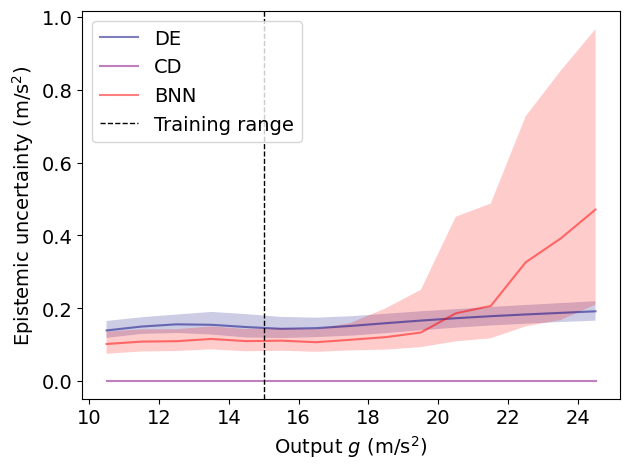

In [ ]:
fontsize=14
fontsize_title=16

x = np.arange(10.5, 25, 1.)
plt.plot(x, y_pred_epunc_de_oodg_50, alpha=0.5, c='#000080', label='DE')
plt.fill_between(x, y_pred_epunc_de_oodg_16, y_pred_epunc_de_oodg_84,
                facecolor='#000080', alpha=0.2)
plt.plot(x, y_pred_epunc_cd_oodg_50, alpha=0.5, c='#800080', label='CD')
plt.fill_between(x, y_pred_epunc_cd_oodg_16, y_pred_epunc_cd_oodg_84,
                facecolor='#800080', alpha=0.2)
plt.plot(x, y_pred_epunc_bnn_oodg_50, alpha=0.5, c='#FF0000', label='BNN')
plt.fill_between(x, y_pred_epunc_bnn_oodg_16, y_pred_epunc_bnn_oodg_84,
                facecolor='#FF0000', alpha=0.2)
plt.axvline(15, ls='--', c='black', linewidth=1, label='Training range')

plt.legend(fontsize=fontsize, loc=2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Output $g$ (m/s$^2$)', fontsize=fontsize)
plt.ylabel('Epistemic uncertainty (m/s$^2$)', fontsize=fontsize)
plt.tight_layout()
plt.savefig('oodg.pdf', format='pdf', dpi=500)
plt.savefig('oodg.png', format='png', dpi=500)